# Univariate Time Series Example

In [4]:
import numpy as np
import math
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/
# https://www.gritfeat.com/explainable-aixai-from-correlation-to-causation-shap-for-lstm-time-series-model/
#http://localhost:8888/lab/tree/MyQuantFinProject/TimeSeriesML-FinMarket/Nachiketa-Hebbar-LSTM/RNN_Youtube.ipynb

In [9]:
ab_path = "../data/SPY-Daily-Y09-Now.csv"
stockname='S&P500'
start_date='2020-01-01'
end_date='2022-12-31'

prediction_col='RSI-MA'

train_ratio=0.9

# define generator
n_input = 22
n_output=1
n_features = 1


# Load Data

In [10]:
df=pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
df.rename(columns={'Date/Time':'Date'},inplace=True)
allCols=list(df.columns)
print(allCols)

df['Date']=df['Date'].apply( lambda  dx :  datetime(dx.year,dx.month,dx.day ))
df.set_index('Date',inplace=True)
df=df.loc[start_date:end_date][[prediction_col]]
print(df.info())
print(df.tail(3))



['Ticker', 'Date', 'Price', 'EMA1', 'EMA2', 'EMA3', 'MACD', 'SIGNAL', 'RSI', 'RSI-MA']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 749 entries, 2020-01-02 to 2022-12-20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RSI-MA  749 non-null    float64
dtypes: float64(1)
memory usage: 11.7 KB
None
            RSI-MA
Date              
2022-12-16   50.77
2022-12-19   47.83
2022-12-20   44.55


# Visualize Chart

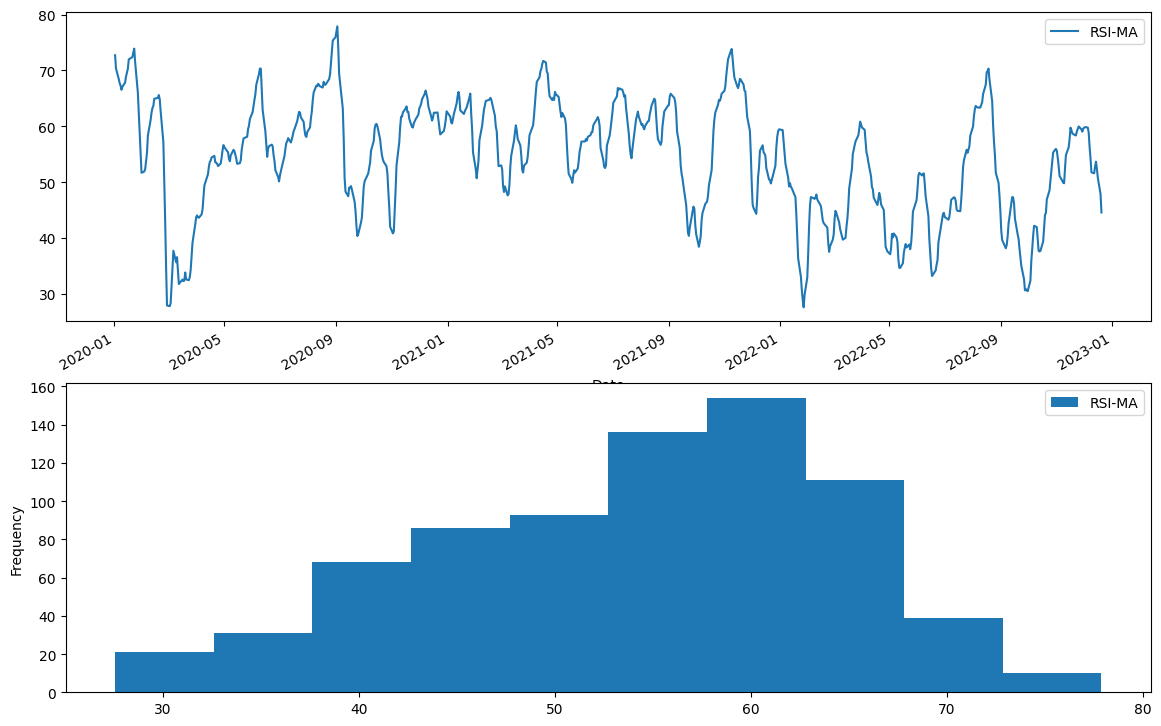

In [11]:
fig, ax_values = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))
df.plot(ax=ax_values[0])
df.plot.hist(ax=ax_values[1])
plt.show()

# Tranform Data

In [12]:
print("Tranform Data")
dfValues=df.values
print(dfValues.shape)
train_data_len = math.ceil(len(dfValues) * train_ratio)
print(f"{train_ratio} of {len(dfValues)} = The number of train data is {train_data_len}")
train_values = dfValues[0:train_data_len]
test_values = dfValues[train_data_len:]
print(train_values.shape,test_values.shape)
    
from sklearn.preprocessing import MinMaxScaler,PowerTransformer
scaler = MinMaxScaler()
#scaler= PowerTransformer()
scaler.fit(train_values)
train = scaler.transform(train_values)
test = scaler.transform(test_values)

print(train.shape,test.shape)
print(type(train),type(test))
print(train[-2:])
print(test[-2:])

Tranform Data
(749, 1)
0.9 of 749 = The number of train data is 675
(675, 1) (74, 1)
(675, 1) (74, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[[0.23926868]
 [0.21025437]]
[[0.40262321]
 [0.33744038]]


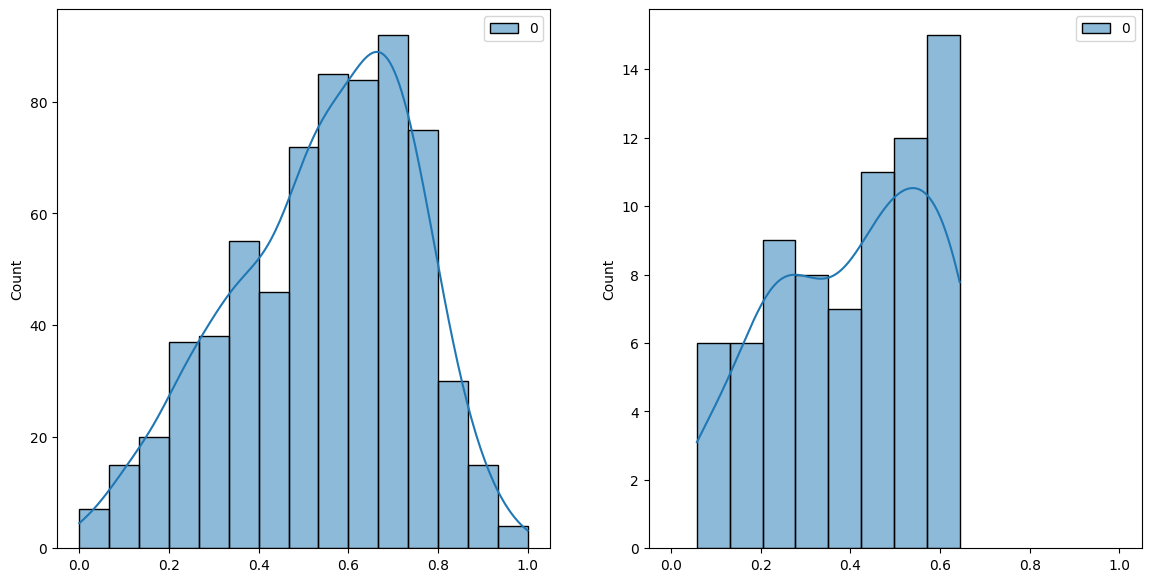

In [13]:
# Plot istribution of the Time variable, which contains transaction data for two days
fig, ax_values = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(14, 7))
sns.histplot(data=train, kde=True, ax=ax_values[0])
sns.histplot(data=test, kde=True, ax=ax_values[1])
plt.show()



# Generate Timeseries For LSTM

In [14]:
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=1)

# number of samples
print(f'Samples: {len(generator)}')
# print each sample
for i in range(len(generator)):
 x, y = generator[i]
 if i<=1:
    print(x.shape,y.shape)  
    print(f'{x} => {y}')
    print("=========================")
    


Samples: 653
(1, 22, 1) (1, 1)
[[[0.89705882]
  [0.8495628 ]
  [0.81279809]
  [0.79789348]
  [0.78934817]
  [0.77424483]
  [0.7845787 ]
  [0.80007949]
  [0.82154213]
  [0.83465819]
  [0.84876789]
  [0.88215421]
  [0.89069952]
  [0.9067965 ]
  [0.92050874]
  [0.87301272]
  [0.76351351]
  [0.69236884]
  [0.61824324]
  [0.55027822]
  [0.47893482]
  [0.48310811]]] => [[0.49125596]]
(1, 22, 1) (1, 1)
[[[0.8495628 ]
  [0.81279809]
  [0.79789348]
  [0.78934817]
  [0.77424483]
  [0.7845787 ]
  [0.80007949]
  [0.82154213]
  [0.83465819]
  [0.84876789]
  [0.88215421]
  [0.89069952]
  [0.9067965 ]
  [0.92050874]
  [0.87301272]
  [0.76351351]
  [0.69236884]
  [0.61824324]
  [0.55027822]
  [0.47893482]
  [0.48310811]
  [0.49125596]]] => [[0.52166137]]


# LSTM Train

In [15]:
#neuron_number=100

np.random.seed(7)
neuron_number=n_input* n_features
print(f"{neuron_number}= {n_input} x {n_features} (univariate n_features=1)")

model = Sequential()

model.add(LSTM(neuron_number, activation='relu',return_sequences=False, input_shape=(n_input, n_features)))  

model.add(Dense(n_output))

#https://keras.io/api/metrics/
# model.compile(optimizer="adam", loss="mean_squared_error")
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

22= 22 x 1 (univariate n_features=1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 22)                2112      
                                                                 
 dense (Dense)               (None, 1)                 23        
                                                                 
Total params: 2,135
Trainable params: 2,135
Non-trainable params: 0
_________________________________________________________________


In [16]:
#history=model.fit_generator(generator, steps_per_epoch=1, epochs=n_epochs, verbose=0)
history=model.fit(generator,epochs=30,batch_size=32,shuffle=False)

Epoch 1/30
653/653 [==============================] - 11s 13ms/step - loss: 0.0241
Epoch 2/30
653/653 [==============================] - 8s 13ms/step - loss: 0.0095
Epoch 3/30
653/653 [==============================] - 10s 15ms/step - loss: 0.0068
Epoch 4/30
653/653 [==============================] - 9s 14ms/step - loss: 0.0060
Epoch 5/30
653/653 [==============================] - 10s 14ms/step - loss: 0.0047
Epoch 6/30
653/653 [==============================] - 9s 14ms/step - loss: 0.0039
Epoch 7/30
653/653 [==============================] - 10s 15ms/step - loss: 0.0034
Epoch 8/30
653/653 [==============================] - 9s 13ms/step - loss: 0.0029
Epoch 9/30
653/653 [==============================] - 9s 14ms/step - loss: 0.0024
Epoch 10/30
653/653 [==============================] - 8s 13ms/step - loss: 0.0020
Epoch 11/30
653/653 [==============================] - 11s 17ms/step - loss: 0.0020
Epoch 12/30
653/653 [==============================] - 11s 16ms/step - loss: 0.0020
Epoch 1

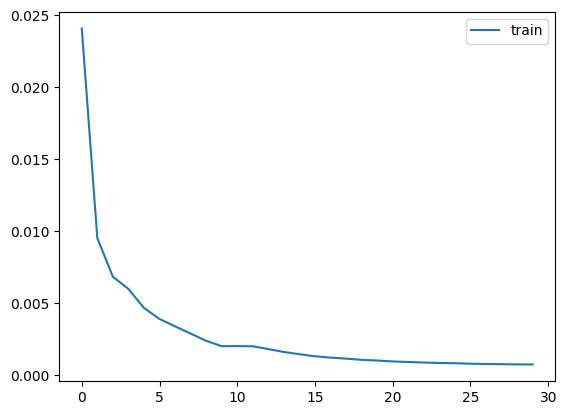

In [17]:
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

# Get Test Data(Unseen) by include {n_input_lookback} to predict

# Set Test data for prediction

In [18]:
# test_arr will get start with the last n look back to predict
idx_train_to_test=len(dfValues)-len(test_values)-n_input
print("The first train data to predict the frist test :",idx_train_to_test)
test_arr=dfValues[idx_train_to_test:]
print(f"Get Test Data {len(test_values)} + {n_input} to predict = {test_arr.shape}")
print(test_arr.shape)
test_scaled_arr=scaler.fit_transform(test_arr)
print(test_scaled_arr.shape)
print(test_scaled_arr[:2])

#No.row = len(test_arr)-n_hop_lookback  , we will start triaing at the first rows since n_hop
X_test=[]
for i in range(n_input,test_scaled_arr.shape[0]):
   X_test.append(test_scaled_arr[i-n_input:i]) 
X_test=np.array(X_test)
print(X_test.shape)
# print(X_test[:2])

The first train data to predict the frist test : 653
Get Test Data 74 + 22 to predict = (96, 1)
(96, 1)
(96, 1)
[[0.82689413]
 [0.82413447]]
(74, 22, 1)


# Prediction

In [19]:
y_test_scaled_pred=model.predict(X_test)
print("Before Invert :",y_test_scaled_pred.shape)
y_test_pred=scaler.inverse_transform(y_test_scaled_pred)
print("After Invert :" ,y_test_pred.shape)
y_test_pred[:2]

3/3 [==============================] - 0s 7ms/step
Before Invert : (74, 1)
After Invert : (74, 1)


array([[37.743732],
       [39.578922]], dtype=float32)

# Create Predction DataFrame and Plot Chart

In [20]:
predResult_col=f'Predict-{prediction_col}'
test_pred_df=pd.DataFrame(y_test_pred,columns=[predResult_col])
test_actual_df=pd.DataFrame(test_values,columns=[prediction_col])
test_df=pd.concat([test_actual_df,test_pred_df],axis=1)
print(test_df.info())
print(test_df.tail())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RSI-MA          74 non-null     float64
 1   Predict-RSI-MA  74 non-null     float32
dtypes: float32(1), float64(1)
memory usage: 1016.0 bytes
None
    RSI-MA  Predict-RSI-MA
69   53.65       53.727898
70   52.39       54.010979
71   50.77       50.740498
72   47.83       48.711456
73   44.55       45.251297


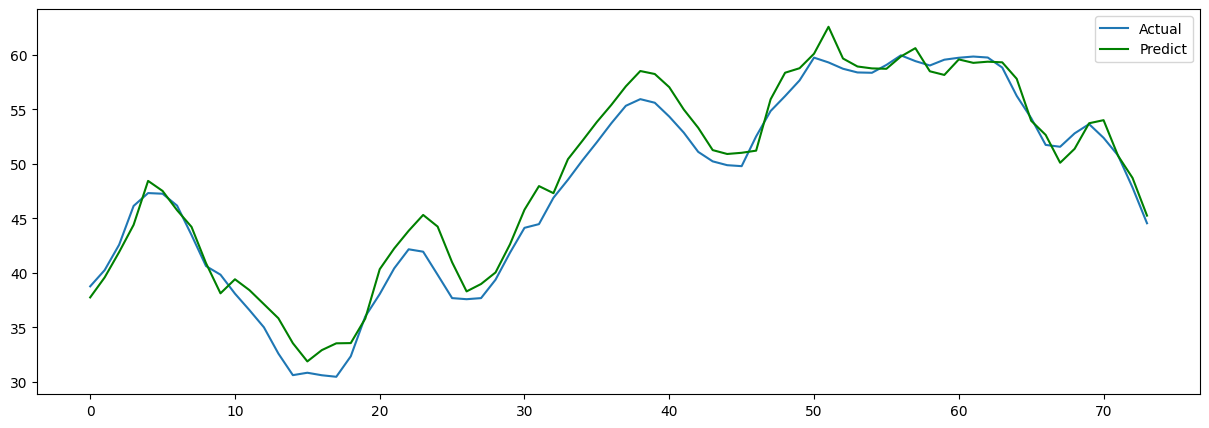

In [21]:
plt.figure(figsize=(15,5))
plt.plot(test_df[prediction_col],label='Actual')
plt.plot(test_df[predResult_col],color='green',label='Predict')
plt.legend()
plt.show()


# Measure

In [17]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
rmse = np.sqrt(mean_squared_error(test_df[prediction_col], test_df[predResult_col]))
print('Root Mean Square Error(RMSE): %.3f' % rmse)
# Mean Absolute Error (MAE)
mae=mean_absolute_error(test_df[prediction_col], test_df[predResult_col])
print('Mean Absolute Error (MAE): ' + str(np.round(mae, 2)))

Root Mean Square Error(RMSE): 10.901
Mean Absolute Error (MAE): 9.01


# Predict One Value

In [22]:
print(f"We will use the last {n_input} data to predict the new one")
last_train_batch=train[-n_input:]
print(last_train_batch.shape,last_train_batch)

print("We need reshape first")
last_train_batch =last_train_batch .reshape((1,n_input,n_features))
print(last_train_batch.shape,last_train_batch)

print("Predict")
last_predict=model.predict(last_train_batch)
print(last_predict)

last_predict = scaler.inverse_transform(last_predict)
print(last_predict.shape,last_predict)


We will use the last 22 data to predict the new one
(22, 1) [[0.71244038]
 [0.71025437]
 [0.71104928]
 [0.71979332]
 [0.729531  ]
 [0.75834658]
 [0.79292528]
 [0.83664547]
 [0.84161367]
 [0.8495628 ]
 [0.81200318]
 [0.73410175]
 [0.65063593]
 [0.58863275]
 [0.54332273]
 [0.47853736]
 [0.44296502]
 [0.39924483]
 [0.34300477]
 [0.27205882]
 [0.23926868]
 [0.21025437]]
We need reshape first
(1, 22, 1) [[[0.71244038]
  [0.71025437]
  [0.71104928]
  [0.71979332]
  [0.729531  ]
  [0.75834658]
  [0.79292528]
  [0.83664547]
  [0.84161367]
  [0.8495628 ]
  [0.81200318]
  [0.73410175]
  [0.65063593]
  [0.58863275]
  [0.54332273]
  [0.47853736]
  [0.44296502]
  [0.39924483]
  [0.34300477]
  [0.27205882]
  [0.23926868]
  [0.21025437]]]
Predict
1/1 [==============================] - 0s 72ms/step
[[0.21539348]]
(1, 1) [[39.045586]]
